In [54]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import warnings
warnings.filterwarnings("ignore")

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
from src.utils import *
from src.cleaning import *

In [59]:
from sklearn.ensemble import RandomForestRegressor
import xgboost 
import lightgbm as lgb
from sklearn.linear_model import Ridge

In [60]:
def print_score(m):
    res = [
        rmse(m.predict(X_train), y_train),
        rmse(m.predict(X_test), y_test),
        m.score(X_train, y_train),
        m.score(X_test, y_test),
    ]
    if hasattr(m, "oob_score_"):
        res.append(m.oob_score_)
    print(res)

In [61]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

#### READ DATA

In [141]:
df_sample_submission = pd.read_csv('data/SampleSubmission.csv')
df_variable_definitions = pd.read_csv('data/VariableDefinitions.csv')

In [142]:
df_train = pd.read_feather('tmp/train')
df_test  = pd.read_feather('tmp/test')

In [143]:
df_train.head()

,index,Distance (KM),Precipitation in millimeters,Temperature,Time from Pickup to Arrival,Age,Average_Rating,delay_in_pickup,unrated,dest_x,...,Pickup - Weekday (Mo = 1)_3,Pickup - Weekday (Mo = 1)_4,Pickup - Weekday (Mo = 1)_5,Pickup - Weekday (Mo = 1)_6,Pickup - Weekday (Mo = 1)_7,Vehicle Type_Bike,Platform Type_1,Platform Type_2,Platform Type_3,Platform Type_4
0,0,4,0.0,20.400000,745.0,1309,13.8,1477.0,1088,0.172366,...,0,0,1,0,0,0,0,0,1,0
1,1,16,0.0,26.400000,1993.0,339,13.6,1021.0,327,0.172503,...,0,0,1,0,0,0,0,0,1,0
2,2,3,0.0,23.255689,455.0,242,12.5,410.0,909,0.171731,...,0,0,0,0,0,0,0,0,1,0
3,3,9,0.0,19.200000,1341.0,283,14.5,711.0,773,0.190806,...,0,0,1,0,0,0,0,0,1,0
4,4,9,0.0,15.400000,1214.0,872,14.1,455.0,1778,0.171522,...,0,0,0,0,0,0,1,0,0,0


In [144]:
df_train.shape

(21201, 34)

In [145]:
df_test.shape

(7068, 34)

In [146]:
df_train.columns

Index(['index', 'Distance (KM)', 'Precipitation in millimeters', 'Temperature',
       'Time from Pickup to Arrival', 'Age', 'Average_Rating',
       'delay_in_pickup', 'unrated', 'dest_x', 'dest_y', 'dest_z', 'pick_x',
       'pick_y', 'pick_z', 'Personal or Business_Business',
       'Personal or Business_Personal', 'Pickup - Day of Month_beg_month',
       'Pickup - Day of Month_endmonth', 'Pickup - Day of Month_midmonth',
       'Pickup - Time_normal', 'Pickup - Time_rush',
       'Pickup - Weekday (Mo = 1)_1', 'Pickup - Weekday (Mo = 1)_2',
       'Pickup - Weekday (Mo = 1)_3', 'Pickup - Weekday (Mo = 1)_4',
       'Pickup - Weekday (Mo = 1)_5', 'Pickup - Weekday (Mo = 1)_6',
       'Pickup - Weekday (Mo = 1)_7', 'Vehicle Type_Bike', 'Platform Type_1',
       'Platform Type_2', 'Platform Type_3', 'Platform Type_4'],
      dtype='object')

In [147]:
df = df_train.drop(['index'],axis=1)

#### Train test split

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(["Time from Pickup to Arrival"],axis=1), df_train['Time from Pickup to Arrival'], test_size=0.33, random_state=42)

In [149]:
X_train = X_train.drop('index',axis=1)
X_test = X_test.drop('index',axis=1)

In [150]:
X_test

,Distance (KM),Precipitation in millimeters,Temperature,Age,Average_Rating,delay_in_pickup,unrated,dest_x,dest_y,dest_z,...,Pickup - Weekday (Mo = 1)_3,Pickup - Weekday (Mo = 1)_4,Pickup - Weekday (Mo = 1)_5,Pickup - Weekday (Mo = 1)_6,Pickup - Weekday (Mo = 1)_7,Vehicle Type_Bike,Platform Type_1,Platform Type_2,Platform Type_3,Platform Type_4
6224,13,0.0,23.255689,1075,13.8,749.0,1494,0.159604,-0.189005,-0.968919,...,0,0,0,0,0,0,0,0,1,0
16205,13,0.0,19.100000,875,13.8,679.0,209,0.161495,-0.219563,-0.962139,...,0,0,1,0,0,0,1,0,0,0
17099,11,0.0,26.600000,1909,13.3,5.0,6850,0.186389,-0.237848,-0.953251,...,0,0,0,0,0,0,0,0,1,0
9892,21,0.0,25.200000,356,14.2,1134.0,795,0.158321,-0.214179,-0.963879,...,0,0,0,0,0,0,0,0,1,0
8487,11,0.0,22.400000,1236,14.2,5.0,1580,0.190422,-0.196657,-0.961803,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20805,5,0.0,23.255689,2715,13.7,833.0,6902,0.172115,-0.202672,-0.964002,...,0,1,0,0,0,0,0,0,1,0
914,1,0.0,23.900000,1509,13.3,126.0,2185,0.192042,-0.238302,-0.952015,...,0,0,0,0,0,0,0,0,1,0
8180,4,83.0,15.800000,1111,14.1,993.0,1177,0.172366,-0.204050,-0.963667,...,0,0,0,0,0,0,0,0,1,0
16826,8,0.0,24.800000,1069,13.8,10.0,592,0.169598,-0.222279,-0.960119,...,1,0,0,0,0,0,0,0,1,0


In [151]:
df_test = df_test.drop(['index','Time from Pickup to Arrival'],axis=1)

#### RandomForests

In [102]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[456.73026533318216, 768.7739695373234, 0.7847651924239729, 0.4004321524395702, 0.3855042602695665]


In [103]:
create_submission(df_sample=df_sample_submission, df_test=df_test, model=m, name='rf-01')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,1313.219861
Order_No_12736,1375.543395
Order_No_768,1386.767569
Order_No_15332,1154.561756
Order_No_21373,1044.087697
...,...
Order_No_3612,1827.708770
Order_No_7657,3113.931165
Order_No_1969,1582.808532


In [104]:
fi = rf_feat_importance(m,X_train)

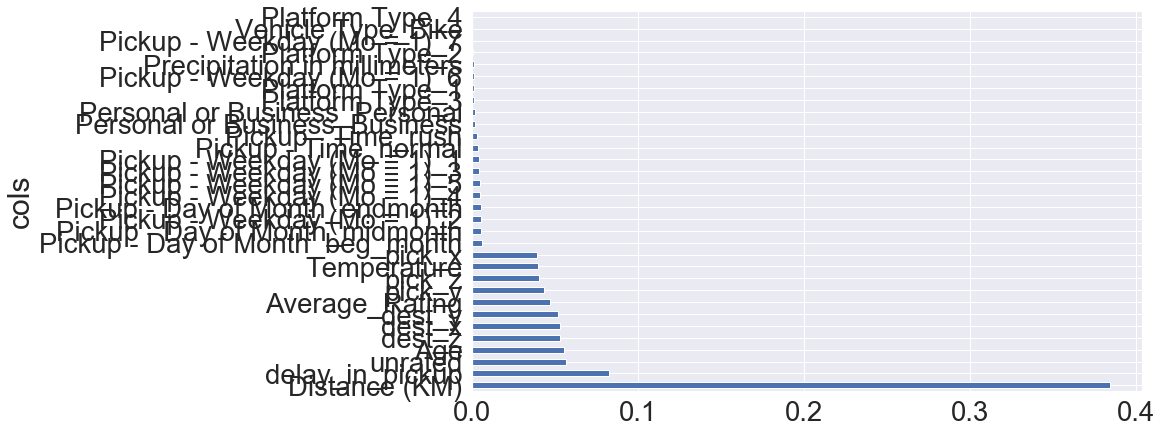

In [105]:
plot_fi(fi)

#### XGBOOST

In [106]:
xgb = xgboost.XGBRegressor(n_estimators=40, learning_rate=0.09, gamma=0, subsample=0.8,
                           colsample_bytree=1, max_depth=7)

In [107]:
xgb.fit(X_train,y_train)
print_score(xgb)

[10:15:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[656.7662422948462, 768.3557215009193, 0.5549440945987852, 0.40108435938268167]


In [108]:
create_submission(df_sample=df_sample_submission, df_test=df_test, model=xgb, name='xgb-02')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,1514.768311
Order_No_12736,1179.573608
Order_No_768,1425.643311
Order_No_15332,1175.053589
Order_No_21373,1156.525391
...,...
Order_No_3612,1413.312744
Order_No_7657,2782.339111
Order_No_1969,1626.793091


#### Ridge

In [109]:
ridge = Ridge(alpha=0.01, normalize = True, random_state=42)

In [110]:
ridge.fit(X_train, y_train)
y = ridge.predict(df_test)

In [111]:
print_score(ridge)

[784.2461990955586, 792.2218804638014, 0.3654033588624997, 0.3633002757303383]


In [112]:
create_submission(df_sample=df_sample_submission, df_test=df_test, model=ridge, name='ridge-01')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,1357.923077
Order_No_12736,1274.254259
Order_No_768,1087.892390
Order_No_15332,1057.325841
Order_No_21373,1108.003877
...,...
Order_No_3612,1015.984134
Order_No_7657,2861.196397
Order_No_1969,1751.591185


#### Light GBM

In [152]:
import lightgbm as lgb

In [153]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [154]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

In [155]:
gbm = lgb.train(params,
                d_train,
                num_boost_round=200,
                valid_sets=d_valid,
                early_stopping_rounds=6)


[1]	valid_0's l1: 735.926	valid_0's l2: 950258
Training until validation scores don't improve for 6 rounds.
[2]	valid_0's l1: 720.339	valid_0's l2: 918237
[3]	valid_0's l1: 705.915	valid_0's l2: 889459
[4]	valid_0's l1: 692.59	valid_0's l2: 863283
[5]	valid_0's l1: 685.152	valid_0's l2: 848114
[6]	valid_0's l1: 673.309	valid_0's l2: 825855
[7]	valid_0's l1: 662.439	valid_0's l2: 805799
[8]	valid_0's l1: 652.222	valid_0's l2: 787668
[9]	valid_0's l1: 642.5	valid_0's l2: 770781
[10]	valid_0's l1: 637.298	valid_0's l2: 761277
[11]	valid_0's l1: 628.867	valid_0's l2: 746782
[12]	valid_0's l1: 624.115	valid_0's l2: 738453
[13]	valid_0's l1: 616.782	valid_0's l2: 725975
[14]	valid_0's l1: 610.025	valid_0's l2: 714487
[15]	valid_0's l1: 603.901	valid_0's l2: 704199
[16]	valid_0's l1: 598.147	valid_0's l2: 694718
[17]	valid_0's l1: 592.855	valid_0's l2: 686217
[18]	valid_0's l1: 588.112	valid_0's l2: 678698
[19]	valid_0's l1: 583.529	valid_0's l2: 671491
[20]	valid_0's l1: 579.484	valid_0's l2

In [156]:
create_submission(df_sample=df_sample_submission, df_test=df_test, model=gbm, name='lgbm-retrial')

,Time from Pickup to Arrival
Order_No,
Order_No_19248,1390.479436
Order_No_12736,1315.421259
Order_No_768,1526.947041
Order_No_15332,1210.469431
Order_No_21373,1136.713373
...,...
Order_No_3612,1566.304671
Order_No_7657,2958.697904
Order_No_1969,1572.484601


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 30):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 2.5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

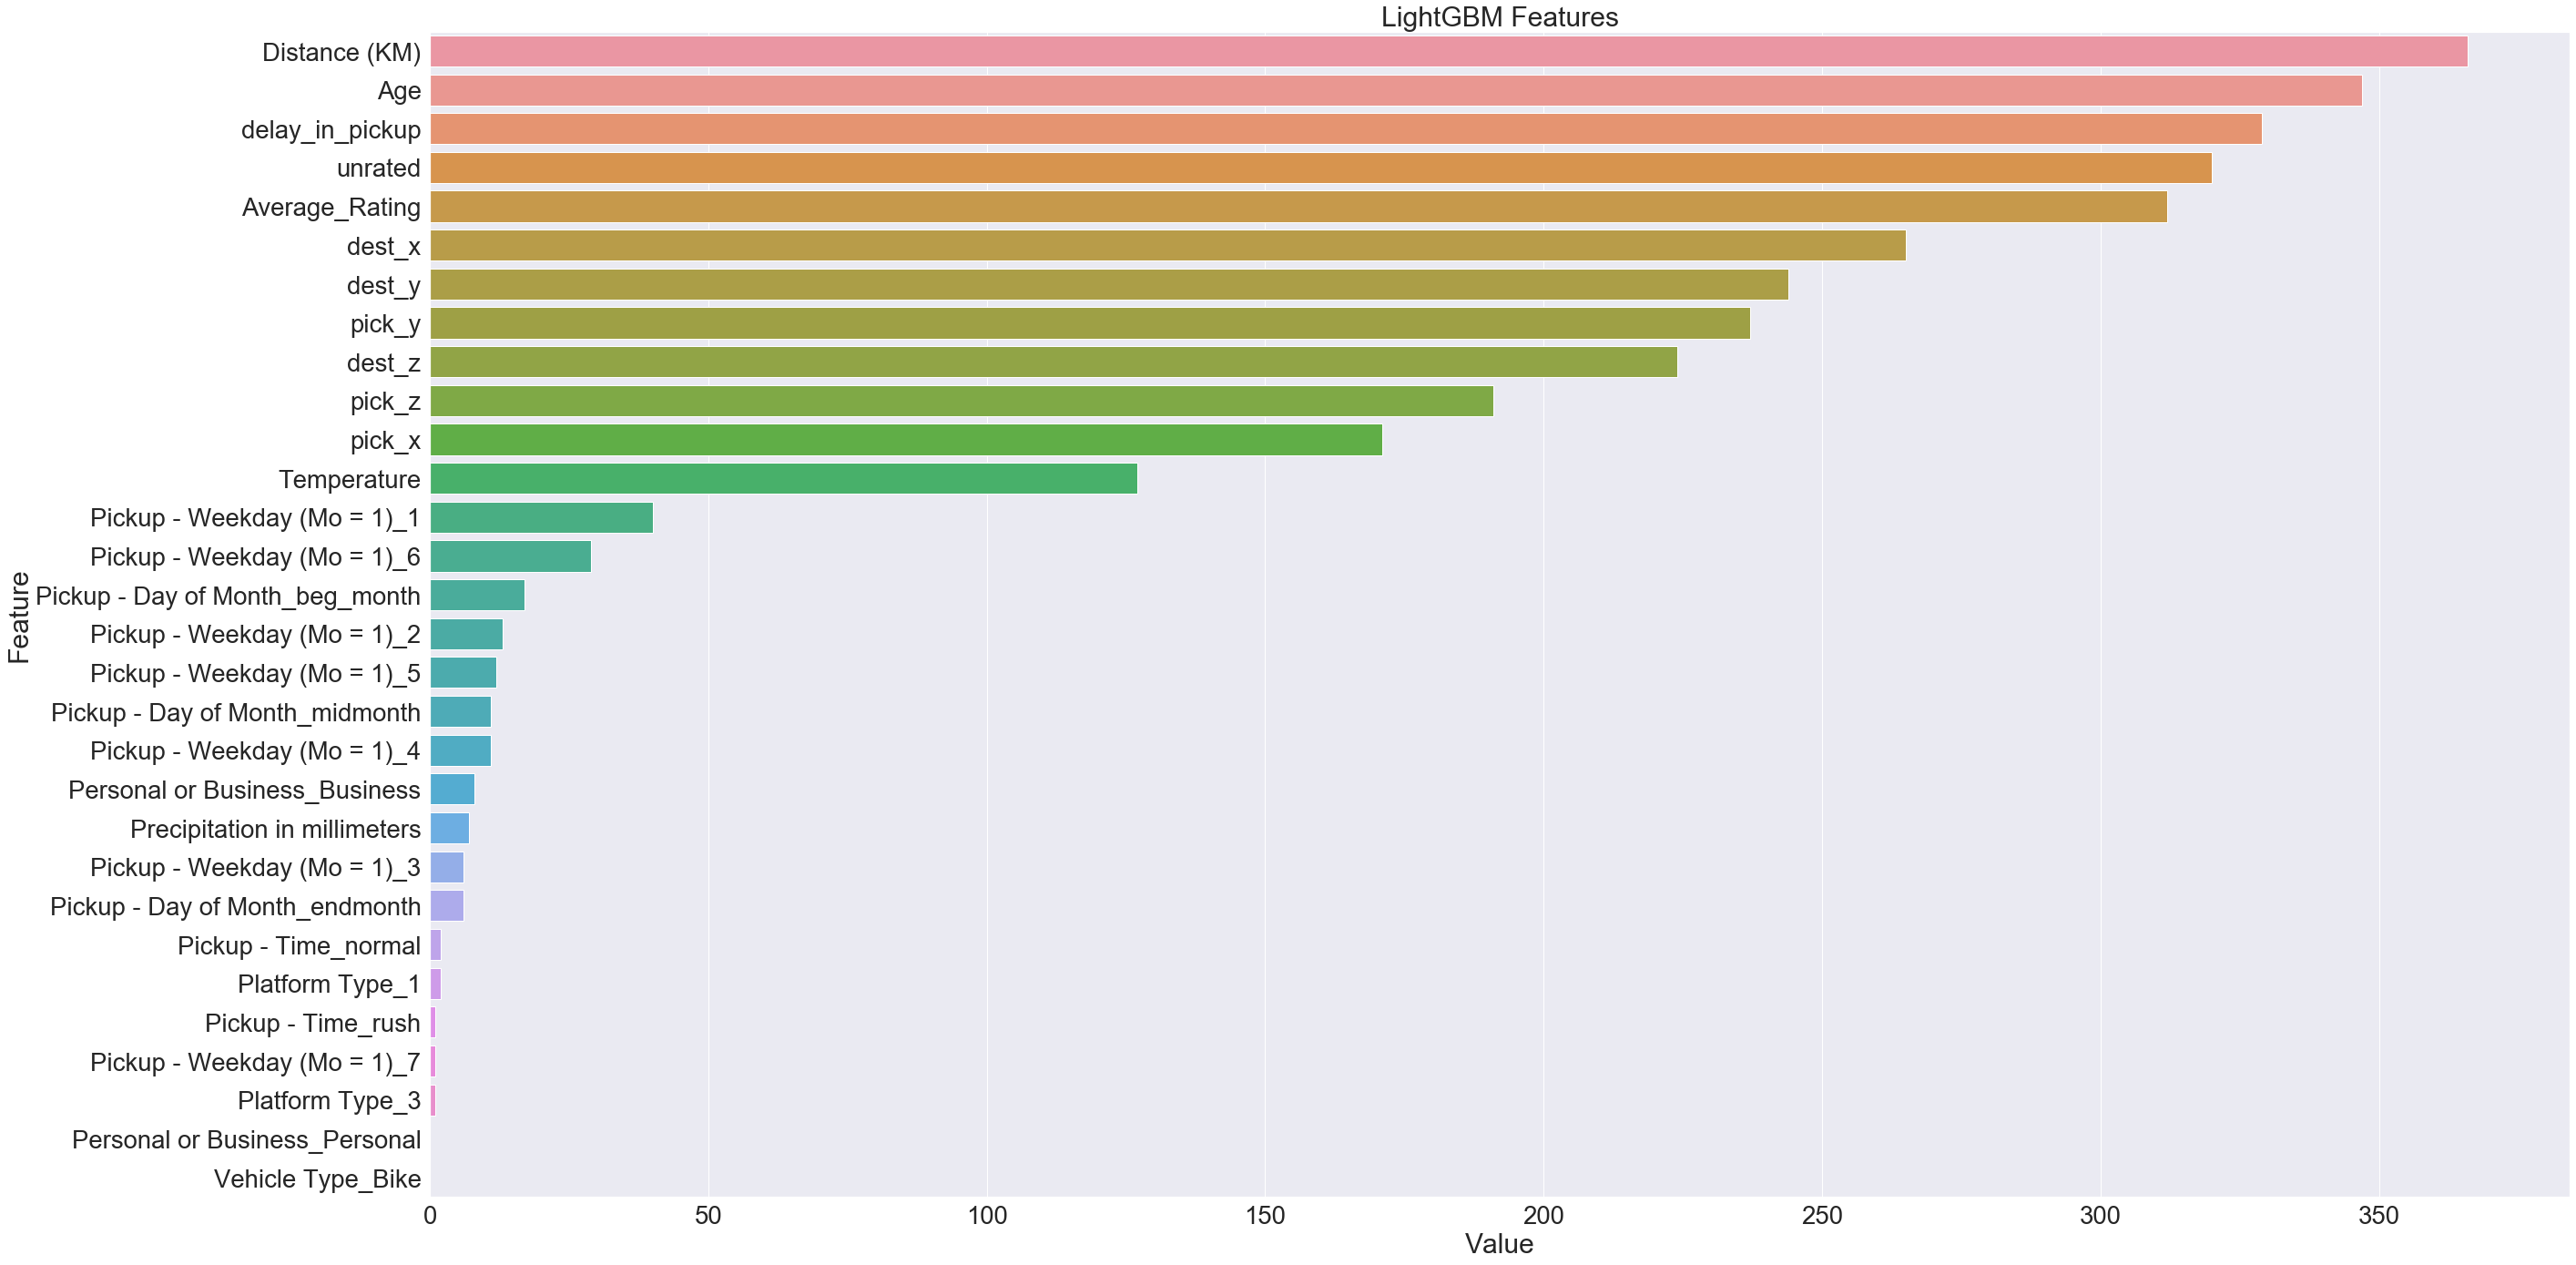

In [119]:
plotImp(gbm,X_train)

In [36]:
X_train.columns.to_list()

['Distance (KM)',
 'Precipitation in millimeters',
 'Temperature',
 'Age',
 'Average_Rating',
 'delay_in_pickup',
 'unrated',
 'dest_x',
 'dest_y',
 'dest_z',
 'pick_x',
 'pick_y',
 'pick_z',
 'Personal or Business_Business',
 'Personal or Business_Personal',
 'Pickup - Day of Month_beg_month',
 'Pickup - Day of Month_endmonth',
 'Pickup - Day of Month_midmonth',
 'Pickup - Time_normal',
 'Pickup - Time_rush',
 'Pickup - Weekday (Mo = 1)_1',
 'Pickup - Weekday (Mo = 1)_2',
 'Pickup - Weekday (Mo = 1)_3',
 'Pickup - Weekday (Mo = 1)_4',
 'Pickup - Weekday (Mo = 1)_5',
 'Pickup - Weekday (Mo = 1)_6',
 'Pickup - Weekday (Mo = 1)_7',
 'Vehicle Type_Bike',
 'Platform Type_1',
 'Platform Type_2',
 'Platform Type_3',
 'Platform Type_4']

In [35]:
df_test['Precipitation in millimeters'].value_counts()

0.0     6869
2.9       15
2.1       15
0.9       14
2.0       13
1.9       13
1.1       12
1.0       11
3.0        9
3.1        7
11.0       7
4.9        7
4.1        5
4.0        4
0.3        4
0.8        4
10.9       4
3.9        4
5.0        3
0.7        3
9.1        3
9.0        3
16.1       3
0.5        3
0.2        3
52.1       2
16.0       2
14.0       2
6.9        2
15.9       2
42.9       2
0.1        2
17.0       2
13.9       2
99.1       2
8.9        2
0.4        1
7.0        1
99.0       1
51.9       1
17.1       1
14.1       1
11.1       1
5.1        1
Name: Precipitation in millimeters, dtype: int64

### Neural networks

In [ ]:
from fastai import *
from fastai.tabular import * 

In [ ]:
dep_var ='Time from Pickup to Arrival' #y_train.copy()

In [ ]:
df_test['Time from Pickup to Arrival'] = 0

In [ ]:
X_test['Time from Pickup to Arrival'] = y_test

In [ ]:
test = TabularList.from_df(df_test,cont_names=list(df_test.drop('Time from Pickup to Arrival',axis=1).columns))

In [ ]:
X_train['Time from Pickup to Arrival'] = y_train

In [ ]:
cont_names = list(df.columns)
dep_var = 'Time from Pickup to Arrival'

In [ ]:
procs = [FillMissing, Categorify, Normalize]

In [ ]:
data = (TabularList.from_df(df_train, path='.',cont_names=cont_names,procs=procs)
        .split_none()
        #.random_split_by_pct(0.2, seed=42)
        .label_from_df(cols=dep_var)
        .add_test(test)
        .databunch()
)

In [ ]:
data.show_batch(rows=10)

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=rmse)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(1, 1e-2)

In [ ]:
learn.fit_one_cycle(15, max_lr =1e-01)

In [ ]:
preds = learn.get_preds(DatasetType.Test)

In [ ]:
preds